Pendulum with dicrete action and continuous space

Uses V-iteration

In [1]:
clear all
addpath('SR_Process_Models/Pendulum swingup/Matlab/')
% use globals to keep the notation as close as possible to the paper
global MFcores rho_option xr Ts ur wrapflag Qdiag Pdiag rho_offset theta p BFtypeV BFtypeP gamma coordflag eomflag Vfilename

In [2]:
Vfilename = '';

In [3]:
eomflag = 1;            % set to 0 to use the physical model and to 1 to use a model obtained by SR (to be manually inserted in f.m)
coordflag = 0;          % set to 0 to have alpha = 0 down and to 1 to have it up
extflag = 0;            % set to 0 to use data in X, set to 1 to use extended data [X; Xnextopt]
plotflag = 0;           % plotting during value-iteration
xnextflag = 0;          % set to 0 to use r(x,u) and to 1 to use r(xnext,u)
wrapflag = 1;           % set to 1 to wrap alpha
xr = [abs(coordflag-1)*pi; 0]; % desired state
Umax = 2;               % maximum control action
BFtypeV = 2;            % V-function approximation type (1 - triangular, 2 - exponential, 3 - parabolic, 4 - polynomial, 5 - scattered, 6 - spline,7 - symbolic)
BFtypeP = 1;            % policy approximation type (1 - triangular, 2 - exponential, 3 - parabolic, 4 - polynomial)
rho_option = 2;         % switch different reward functions(1 - quadratic, 2 - abs, 3 - sqrt)
gamma = 0.95;           % discount factor
Qdiag = [0.5 0.01];     % diagonal of the reward Q matrix
Pdiag = 0.05;           % diagonal of the reward P matrix
Ts = 0.05;              % sampling period
% xdom = [-1*pi 1*pi;     % state-space domain limits - angle
%         -30 30];        % state-space domain limits - angular velocity
xdom = [0 2*pi;         % state-space domain limits - angle
        -30 30];        % state-space domain limits - angular velocity
nX = 1000;              % number of points for scattered interpolation
rho_offset = 0;         % offset of the reward function value
PIflag = 0;             % set to 1 for policy iteration, to 0 for value iteration

In [4]:
n1 = 7;                % number of BF for x(1)
n2 = 7;                % number of BF for x(2)
nr = 1;                 % refine data nr times for plotting
maxiter = 1000;         % number of VI (PI) iterations
epstheta = 1e-4;        % stopping criterion threshold
su = 0.01;              % fine step for u around ur

In [5]:
if(eomflag == 0)
    ur = fminbnd(@(u) sum((xr-f(xr',u)').^2), -10, 10); 	% control action corresponding to desired state
elseif(eomflag == 1)
    ur = fminbnd(@(u) sum((xr-fsm(xr',u)').^2), -10, 10); 	% control action corresponding to desired state
end
if ur < su/100, ur = 0; end;
U = [-Umax:1:Umax fliplr(ur-su:-su:ur-.5) ur:su:ur+.5]';
U = sort(unique(U));    % keep unique values of control actions and sort them
U = [-Umax:0.1:Umax]';
nU = size(U,1);         % number of action samples

In [6]:
s1 = diff(xdom(1,:))/(n1-1);    % step for basis function cores in x(1)
s2 = diff(xdom(2,:))/(n2-1);    % step for basis function cores in x(2)
MFcores = {[fliplr(xr(1)-s1:-s1:xdom(1,1)) xr(1):s1:xdom(1,2)]; ...
    [fliplr(xr(2)-s2:-s2:xdom(2,1)) xr(2):s2:xdom(2,2)]};   % basis function cores
% K = length(MFcores{1})*length(MFcores{2});                  % total number of basis functions

In [7]:
[x1,x2] = ndgrid(MFcores{1},MFcores{2});
X = [x1(:) x2(:)];      % data set to optimize on

In [8]:
load Xnextopt
Xe = [X; Xnextopt];
nXe = size(Xe,1);         % number of state samples

In [9]:
if BFtypeV == 5,
    X = 2*(0.5-rand(nX,2)).*(ones(nX,1)*[pi 30]);           % generate random points
end;
nX = size(X,1);         % number of state samples

In [10]:
% fine grid for plotting
[xx1,xx2] = ndgrid([fliplr(xr(1)-s1/nr:-s1/nr:min(MFcores{1})) xr(1):s1/nr:max(MFcores{1})], ...
                    [fliplr(xr(2)-s2/nr:-s2/nr:min(MFcores{2})) xr(2):s2/nr:max(MFcores{2})]);
XX = [xx1(:) xx2(:)];   % data set to generate plots

In [11]:
fprintf('Precomputing state transitions ...\n');
if eomflag == 0
    [Xnext,Urep] = f(X,U);                          % compute next state for all actions (stacked in Xnext) using eom
else
    [Xnext,Urep] = fsm(X,U);                        % compute next state for all actions (stacked in Xnext) using symbolic model
end

Precomputing state transitions ...


In [12]:
indX = any(Xnext > repmat(max(X),size(Xnext,1),1) | Xnext < repmat(min(X),size(Xnext,1),1),2);      % indices of next states that fall outside the domain

In [13]:
if xnextflag == 1
    r = rho(Xnext,Urep);                            % pre-compute rho over all actions using next state
else    
    r = rho(repmat(X,length(U),1),Urep);            % pre-compute rho over all actions using current state
end;    
% r(indX,:) = -1e10;
if BFtypeV ~= 5,
    PhiV = tmprodvect(X,MFcores,BFtypeV);           % basis function values for all current states
    PhinextV = tmprodvect(Xnext,MFcores,BFtypeV);   % basis function values for future states
    PhixxV = tmprodvect(XX,MFcores,BFtypeV);        % evaluate BF for visualization data
    PhiP = tmprodvect(X,MFcores,BFtypeP);           % basis function values for current states
    PhixxP = tmprodvect(XX,MFcores,BFtypeP);        % evaluate BF for visualization data
    % Phi = sparse(Phi);
    KV = size(PhiV,2);                              % total number of basis functions
    KP = size(PhiP,2);                              % total number of basis functions
else
    DT = delaunayTriangulation(X);
    [ti,bc] = pointLocation(DT,Xnext);
    ind = ~isnan(ti);
    DTind = DT(ti(ind),:);
    KV = size(X,1);                         % total number of basis functions
    KP = KV;                                % total number of basis functions    
end;

In [14]:
theta = 0*randn(KV,maxiter);                % initial value function parameters
p = zeros(KP,maxiter);                      % policy parameters
V = xx1;
P = V;

In [15]:
theta(:,1) = max(reshape(r,nX,nU),[],2);    % use reward to initialize V function parameters
%theta(:,1) = [-117748.27529638; -0.009436; 10.52001016; -14.42369145; 235.19477339; 1.90537646; 0.06125907; 0.75812601; 3.539E-5; 3.51E-6; -0.1119752];
% theta(:,1) = [-7.21773756 / (1.0 - 0.95); 13.79972273; 0.89680721; -5.24539182; 1.74426011; 1.53286872; -8.00413901; -3.45302201; -3.14E-6; 6.812E-5; 0.81078732];
%theta(:,1) = [-209.20822470129664; 0.19566459; 1.52888192; 74.99785322; -0.03714352; -0.20372314; 0.02157719; 0.04181519; -1.13392594; 0.03255163; 1.4E-7];
% theta(:,1) = [-0.6777083413036449 / (1.0 - 0.95); -288.89041375; 0.00130654; 0.52547764; 3.12008377; -0.8078517; 1.42518149; -17.8175546; 1.48205744; -0.00162679; 2.15520596; 0.01582812; -1.76479988];
% theta(:,1) = feval(Vfilename);
th = x1;

In [16]:
fprintf('iteration: '); 
for j = 2 : maxiter                         % VI / PI iterations
    fprintf('%02d,', j-1)
    if rem(j-1,30) == 0, fprintf('\niteration: '); end;
    if BFtypeV == 1 || BFtypeV == 3         % normalized basis functions, assign direct, no LS estimation needed
        if PIflag == 0
            if extflag == 0
                [theta(:,j),maxUind] = max(reshape(r + gamma*PhinextV*theta(:,j-1),nX,nU),[],2);    % Bellman equation RHS
                p(:,j) = U(maxUind);            % optimal action
                if eomflag == 0
                    Xnextopt = f(X,U(maxUind),1);       % next state based on current policy using eom
                else
                    Xnextopt = fsm(X,U(maxUind),1);     % next state based on current policy using symbolic model
                end;
            else
                [theta_target,maxUind] = max(min(inf,reshape(re + gamma*PhinextVe*theta(:,j-1),nXe,nU)),[],2);  % Bellman equation RHS
                theta(:,j) = min(0,PhiVe\theta_target);      % LS estimate of V-function parameters
                p_target = U(maxUind);                      % target for the LS estimate of optimal action
                p(:,j) = PhiPe \ p_target;                   % LS estimate of policy parameters
            end;
        else
            u = tmprodvect(X,MFcores,BFtypeP)*p(:,j-1); % current policy
            if eomflag == 0
                Xnxt = f(X,u,1);                        % next state based on current policy using eom
            else
                Xnxt = fsm(X,u,1);                      % next state based on current policy using symbolic model
            end;
            theta(:,j) = (tmprodvect(X,MFcores,BFtypeV)-gamma*tmprodvect(Xnxt,MFcores,BFtypeV)) \ rho(Xnxt,u);  % estimate value function for current policy
            [~,maxUind] = max(reshape(r + gamma*PhinextV*theta(:,j),nX,nU),[],2);    % improve policy
            p(:,j) = U(maxUind);                % improved policy parameters
        end;
    elseif BFtypeV == 6                     % cubic spline
        th(:) = theta(:,j-1);               % reshape theta for interp2
        [theta(:,j),maxUind] = max(min(0,reshape(r + gamma*interp2(x1',x2',th',Xnext(:,1),Xnext(:,2),'cubic'),nX,nU)),[],2);    % Bellman equation RHS
        p(:,j) = U(maxUind);                % optimal action
    elseif BFtypeV == 2 || BFtypeV == 4 || BFtypeV == 7 % prepare for least-squares estimate
        if PIflag == 0
            [theta_target,maxUind] = max(min(inf,reshape(r + gamma*PhinextV*theta(:,j-1),nX,nU)),[],2);  % Bellman equation RHS
%             theta_target = theta_target - max(theta_target);
            theta(:,j) = PhiV\theta_target;             % LS estimate of V-function parameters
            p_target = U(maxUind);                      % target for the LS estimate of optimal action
            p(:,j) = PhiP \ p_target;                   % LS estimate of policy parameters
        else
            u = tmprodvect(X,MFcores,BFtypeP)*p(:,j-1); % current policy
            if eomflag == 0
                Xnxt = f(X,u,1);                        % next state based on current policy using eom
            else
                Xnxt = fsm(X,u,1);                      % next state based on current policy using symbolic model
            end;
            theta(:,j) = (tmprodvect(X,MFcores,BFtypeV)-gamma*tmprodvect(Xnxt,MFcores,BFtypeV)) \ rho(Xnxt,u);  % estimate value function for current policy
            [~,maxUind] = max(reshape(r + gamma*PhinextV*theta(:,j),nX,nU),[],2);    % improve policy
            p(:,j) = U(maxUind);                % improved policy parameters
        end;
    elseif BFtypeV == 5
%         F = scatteredInterpolant(X(:,1),X(:,2),theta(:,j-1));
%         [theta(:,j),maxUind] = max(reshape(r + gamma*F(Xnext(:,1),Xnext(:,2)),nX,nU),[],2); % Bellman equation RHS
        tt = theta(:,j-1);
        tt(ind) = sum(bc(ind,:).*tt(DTind),2);
        [theta(:,j),maxUind] = max(reshape(r + gamma*tt,nX,nU),[],2); % Bellman equation RHS
        p(:,j) = U(maxUind);                % optimal action
    else
        disp('Invalid type of basis functions.')
    end;
    if max(abs(theta(:,j) - theta(:,j-1))) < epstheta, break; end;   % convergence check
end;
fprintf('\n'); 
theta = theta(:,1:j);                   % cut off unused parameter storage
p = p(:,1:j);                           % cut off unused parameter storage

iteration: 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
iteration: 31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,
iteration: 61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,
iteration: 91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,


In [17]:
if BFtypeV ~= 5,
    V(:) = PhixxV*theta(:,end);             % calculate final V function
    P(:) = PhixxP*p(:,end);                 % calculate final policy
else
    F = scatteredInterpolant(X(:,1),X(:,2),theta(:,end));
    V(:) = F(XX(:,1),XX(:,2));
    F = scatteredInterpolant(X(:,1),X(:,2),p(:,end));
    P(:) = F(XX(:,1),XX(:,2));              % calculate final policy
end;

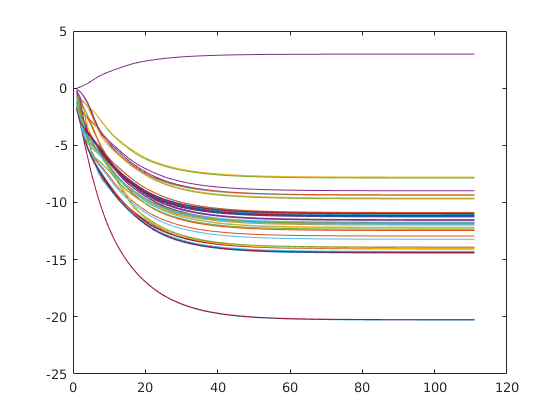

In [18]:
figure(1); clf; plot(theta');           % plot value function parameter convergence

In [19]:
% save data
filename = ['Ref=' num2str(round(180*xr(1)/pi)) '_Umax=' num2str(Umax) '_Qvel=' num2str(Qdiag(2)) '_Grid=' num2str(n1) '_gamma=' num2str(gamma)];
filename = strrep(filename, '.', ',');  % replace dots by commas
switch rho_option
    case 1, filename = [filename '_quad'];
    case 2, filename = [filename '_abs'];
    case 3, filename = [filename '_sqrt'];
end;
switch BFtypeV
    case 1, filename = [filename '_lin'];
    case 2, filename = [filename '_exp'];
    case 3, filename = [filename '_par'];
end;
%save(filename);

% plotV_movie;

In [20]:
%% generate data for SNGP 
XnextShaped = reshape(Xnext, length(X), nU, length(xr));
r = rho(Xnext,Urep);
rShaped = reshape(r, length(X), nU);
summary = zeros(length(X), length(xr)+length(xr)*3);
counter = length(xr)+1;
summary(:,1:length(xr)) = X;
for i=1:nU
    summary(:, counter:counter+2) = [reshape(XnextShaped(:,i,:), nX, length(xr)) rShaped(:,i)];
    counter = counter+length(xr)+1;
end